In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Load the datasets
creditcard_data = pd.read_csv('../data/creditcard.csv')
creditcard_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
fraud_data = pd.read_csv('../data/Fraud_cleaned_data.csv')
fraud_data.head()

,purchase_value,age,ip_address,class,frequency,velocity,hour_of_day,day_of_week,time_diff,signup_hour,signup_day_of_week,purchase_day_of_week,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M
0,0.172414,0.362069,0.170603,0,1,34,0.086957,0.833333,4506682.0,22,1,5,False,True,False,False,False,False,True
1,0.048276,0.603448,0.081554,0,1,16,0.043478,0.000000,17944.0,20,6,0,False,False,False,False,False,False,False
2,0.041379,0.603448,0.610371,1,1,15,0.782609,0.500000,1.0,18,3,3,False,True,False,False,True,False,True
3,0.241379,0.396552,0.894219,0,1,44,0.565217,0.000000,492085.0,21,1,0,False,True,False,False,False,True,True
4,0.206897,0.465517,0.096752,0,1,39,0.782609,0.333333,4361461.0,7,1,2,False,False,False,False,False,True,True


In [4]:
# Data Preprocessing for Credit Card Data
X_creditcard = creditcard_data.drop(columns=['Class'])  # Features
y_creditcard = creditcard_data['Class']                 # Target

# Data Preprocessing for Fraud Data
X_fraud = fraud_data.drop(columns=['class'])  # Features
y_fraud = fraud_data['class']                 # Target



In [5]:
# Train-test split
X_train_creditcard, X_test_creditcard, y_train_creditcard, y_test_creditcard = train_test_split(
    X_creditcard, y_creditcard, test_size=0.2, random_state=42, stratify=y_creditcard
)

X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(
    X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud
)

In [6]:
# Standardize the features (important for LSTMs)
scaler = StandardScaler()
X_train_creditcard = scaler.fit_transform(X_train_creditcard)
X_test_creditcard = scaler.transform(X_test_creditcard)

X_train_fraud = scaler.fit_transform(X_train_fraud)
X_test_fraud = scaler.transform(X_test_fraud)



In [7]:
# Reshape the data to 3D for LSTM (samples, time steps, features)
X_train_creditcard = np.reshape(X_train_creditcard, (X_train_creditcard.shape[0], 1, X_train_creditcard.shape[1]))
X_test_creditcard = np.reshape(X_test_creditcard, (X_test_creditcard.shape[0], 1, X_test_creditcard.shape[1]))

X_train_fraud = np.reshape(X_train_fraud, (X_train_fraud.shape[0], 1, X_train_fraud.shape[1]))
X_test_fraud = np.reshape(X_test_fraud, (X_test_fraud.shape[0], 1, X_test_fraud.shape[1]))



In [8]:
# Convert labels to categorical
y_train_creditcard = to_categorical(y_train_creditcard)
y_test_creditcard = to_categorical(y_test_creditcard)

y_train_fraud = to_categorical(y_train_fraud)
y_test_fraud = to_categorical(y_test_fraud)


In [9]:
# Define the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64))
    model.add(Dropout(0.2))
    model.add(Dense(units=2, activation='softmax'))  # 2 output units for binary classification
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
# Build LSTM models for both datasets
lstm_creditcard = build_lstm_model((X_train_creditcard.shape[1], X_train_creditcard.shape[2]))
history_creditcard = lstm_creditcard.fit(X_train_creditcard, y_train_creditcard, epochs=10, batch_size=64, validation_data=(X_test_creditcard, y_test_creditcard))


c:\Users\getac\anaconda3\envs\myenve\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9952 - loss: 0.0573 - val_accuracy: 0.9993 - val_loss: 0.0031
Epoch 2/10
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9994 - loss: 0.0029 - val_accuracy: 0.9993 - val_loss: 0.0030
Epoch 3/10
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9994 - loss: 0.0028 - val_accuracy: 0.9993 - val_loss: 0.0030
Epoch 4/10
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9994 - loss: 0.0028 - val_accuracy: 0.9994 - val_loss: 0.0026
Epoch 5/10
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9995 - loss: 0.0021 - val_accuracy: 0.9994 - val_loss: 0.0027
Epoch 6/10
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9996 - loss: 0.0018 - val_accuracy: 0.9992 - val_loss: 0.0031
Epoch 7/10
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9996 - loss: 0.0017 - val_accuracy: 0.9993 - val_loss: 0.0030
Epoch 8/10
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9996 - loss: 0

In [11]:
# Train the models
lstm_fraud = build_lstm_model((X_train_fraud.shape[1], X_train_fraud.shape[2]))
history_fraud = lstm_fraud.fit(X_train_fraud, y_train_fraud, epochs=10, batch_size=64, validation_data=(X_test_fraud, y_test_fraud))

Epoch 1/10
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9115 - loss: 0.3021 - val_accuracy: 0.9512 - val_loss: 0.2000
Epoch 2/10
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9501 - loss: 0.1998 - val_accuracy: 0.9497 - val_loss: 0.1932
Epoch 3/10
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9523 - loss: 0.1917 - val_accuracy: 0.9518 - val_loss: 0.1891
Epoch 4/10
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9545 - loss: 0.1852 - val_accuracy: 0.9542 - val_loss: 0.1851
Epoch 5/10
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9553 - loss: 0.1826 - val_accuracy: 0.9541 - val_loss: 0.1847
Epoch 6/10
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9548 - loss: 0.1836 - val_accuracy: 0.9545 - val_loss: 0.1834
Epoch 7/10
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9562 - loss: 0.1794 - val_accuracy: 0.9549 - val_loss: 0.1831
Epoch 8/10
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9556 - loss: 0.1816 - 

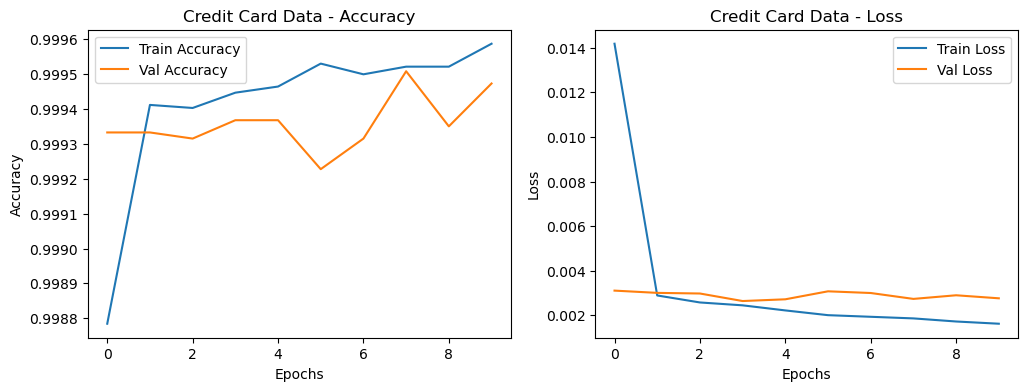

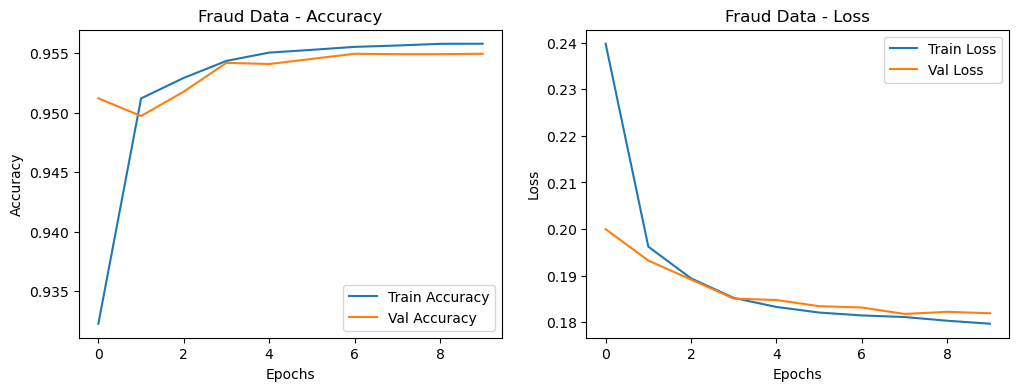

In [12]:
# Function to plot Training vs Validation accuracy and loss
def plot_training_history(history, dataset_name):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{dataset_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{dataset_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

# Plot training vs validation accuracy and loss
plot_training_history(history_creditcard, "Credit Card Data")
plot_training_history(history_fraud, "Fraud Data")


In [13]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, dataset_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {dataset_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report for Credit Card Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.83      0.84        98

    accuracy                           1.00     56962
   macro avg       0.93      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



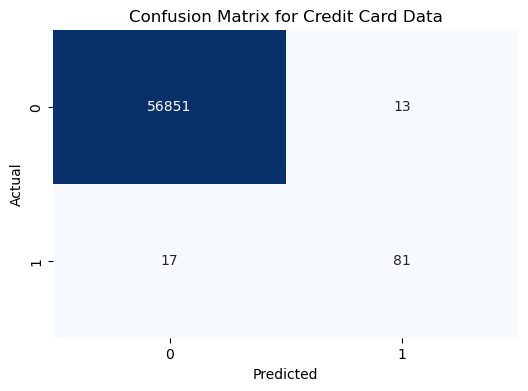

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Classification Report for Fraud Data:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       0.98      0.53      0.69      2830

    accuracy                           0.95     30223
   macro avg       0.97      0.76      0.83     30223
weighted avg       0.96      0.95      0.95     30223



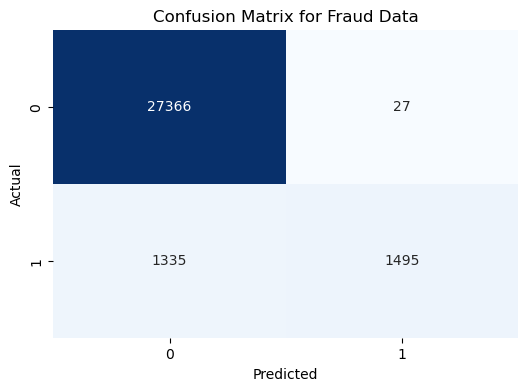

In [14]:
# Function to evaluate the model
def evaluate_model(model, X_test, y_test, dataset_name):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Get the predicted classes
    y_true_classes = np.argmax(y_test, axis=1)  # Get the true classes
    
    # Calculate accuracy, precision, recall, F1 score
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average='weighted')
    
    # Print classification report
    print(f"\nClassification Report for {dataset_name}:")
    print(classification_report(y_true_classes, y_pred_classes))
    
    # Plot confusion matrix
    plot_confusion_matrix(y_true_classes, y_pred_classes, dataset_name)
    
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1}

# Evaluate the models
creditcard_metrics = evaluate_model(lstm_creditcard, X_test_creditcard, y_test_creditcard, "Credit Card Data")
fraud_metrics = evaluate_model(lstm_fraud, X_test_fraud, y_test_fraud, "Fraud Data")

# Combine the metrics into a dictionary for comparison
model_comparison_metrics = {
    'Credit Card Data': creditcard_metrics,
    'Fraud Data': fraud_metrics
}


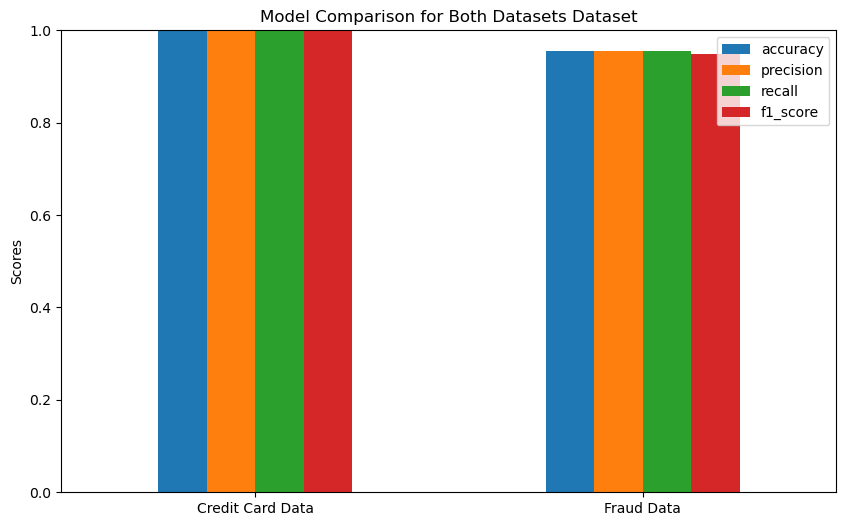

In [15]:
# Function to plot model comparison based on metrics
def plot_model_comparison(metrics_dict, dataset_name):
    metrics_df = pd.DataFrame(metrics_dict).T  # Transpose for easier plotting
    metrics_df.plot(kind='bar', figsize=(10, 6))
    
    plt.title(f'Model Comparison for {dataset_name} Dataset')
    plt.ylabel('Scores')
    plt.xticks(rotation=0)
    plt.ylim(0, 1)  # Ensure the y-axis goes from 0 to 1 for better comparison
    plt.legend(loc='upper right')
    plt.show()

# Plot the comparison of accuracy, precision, recall, and F1 score for both datasets
plot_model_comparison(model_comparison_metrics, "Both Datasets")



In [16]:
import os

# Create the directory to save the models if it doesn't exist
model_dir = '../notebooks/model/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save the LSTM models after training
lstm_creditcard.save(os.path.join(model_dir, 'lstm_creditcard.h5'))
lstm_fraud.save(os.path.join(model_dir, 'lstm_fraud.h5'))

print("Models saved successfully!")


Models saved successfully!
